<h2>1 - Data Preperation<h2>

<h3>1.1 - Importing Data/Libraries</h3>

<p> We begin by importing the stock and reddit data we have gathered.</p>

In [17]:
import pandas as pd
import numpy as np
from Analyzer import Analyzer
from LSTM import LSTM
from Markov import Markov
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [18]:
df1 = pd.read_json('./Datasets/generated_data_Economics.json')
df2 = pd.read_csv('./Datasets/VOO.csv')

In [19]:
#Subreddit Data
df1.head()

,Economics
2022-09-01 12:40:00,"{'polarity': 0.4, 'subjectivity': 0.7000000000..."
2022-09-01 12:42:00,"{'polarity': 0.5, 'subjectivity': 0.6000000000..."
2022-09-01 12:43:00,"{'polarity': 0.1, 'subjectivity': 0.4, 'compou..."
2022-09-01 12:44:00,"{'polarity': 0.5, 'subjectivity': 0.925, 'comp..."
2022-09-01 12:47:00,"{'polarity': 0.1071428571, 'subjectivity': 0.3..."


In [20]:
#Stock Data
df2.head()

,Unnamed: 0,Adj Close
0,2022-08-29 09:30:00-04:00,369.648010
1,2022-08-29 09:31:00-04:00,369.799988
2,2022-08-29 09:33:00-04:00,370.220001
3,2022-08-29 09:34:00-04:00,370.549988
4,2022-08-29 09:35:00-04:00,370.299988


<h3>1.2 - Preparing The Subreddit Sentiment Data </h3>

In [21]:
#Bring out date/time data from index
df1.reset_index(inplace=True)
df1['index'] = pd.to_datetime(df1['index'])
df1['date'] = df1['index'].dt.date

#Group times and their corresponding sentiment data into a list by day
df1['time'] = df1['index']
df1 = df1.groupby('date').agg(list)
df1.reset_index(inplace=True)

#Create final dataframe
df1 = df1[['date', 'time', 'Economics']]
df1.head()

,date,time,Economics
0,2022-09-01,"[2022-09-01 12:40:00, 2022-09-01 12:42:00, 202...","[{'polarity': 0.4, 'subjectivity': 0.700000000..."
1,2022-09-02,"[2022-09-02 09:41:00, 2022-09-02 09:42:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo..."
2,2022-09-03,"[2022-09-03 09:36:00, 2022-09-03 09:38:00, 202...","[{'polarity': 0.1, 'subjectivity': 1.3, 'compo..."
3,2022-09-04,"[2022-09-04 09:42:00, 2022-09-04 09:43:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo..."
4,2022-09-05,"[2022-09-05 12:56:00, 2022-09-05 13:00:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo..."


<h3>1.3 - Preparing The Stock Price Data<h3>

In [22]:
#Bring out date/time data from index
df2['date_time'] = pd.to_datetime(df2['Unnamed: 0'])
df2['date'] = df2['date_time'].dt.date
df2['time'] = df2['date_time'].dt.tz_localize(None)

#Group times and their corresponding price data into a list by day
df2 = df2.groupby('date').agg(list)
df2.reset_index(inplace=True)

#Create Final Dataframe
df2.rename(columns={'Adj Close': 'price'}, inplace=True)
df2 = df2[['price', 'date', 'time']]
df2.head(5)


,price,date,time
0,"[369.6480102539063, 369.7999877929688, 370.220...",2022-08-29,"[2022-08-29 09:30:00, 2022-08-29 09:31:00, 202..."
1,"[371.2200012207031, 370.760009765625, 371.0400...",2022-08-30,"[2022-08-30 09:30:00, 2022-08-30 09:31:00, 202..."
2,"[367.0400085449219, 367.0700073242188, 366.660...",2022-08-31,"[2022-08-31 09:30:00, 2022-08-31 09:31:00, 202..."
3,"[361.5299987792969, 360.8349914550781, 360.959...",2022-09-01,"[2022-09-01 09:30:00, 2022-09-01 09:31:00, 202..."
4,"[367.3999938964844, 366.8800048828125, 366.709...",2022-09-02,"[2022-09-02 09:30:00, 2022-09-02 09:31:00, 202..."


<h3>1.4 - Merging The Sentiment Data And Stock Price Data<h3>

In [23]:
#merge stock/sentiment data according to the date value
df = pd.merge(df1, df2, how='outer', on='date')
df['date'] =  pd.to_datetime(df['date'])
df.rename(columns={'time_x': 'sentiment_time', 'time_y':'stock_time'}, inplace=True)

#get rid of rows that have no sentiment data
df.dropna(inplace=True)
df['na'] = np.nan
df.head()

,date,sentiment_time,Economics,price,stock_time,na
0,2022-09-01,"[2022-09-01 12:40:00, 2022-09-01 12:42:00, 202...","[{'polarity': 0.4, 'subjectivity': 0.700000000...","[361.5299987792969, 360.8349914550781, 360.959...","[2022-09-01 09:30:00, 2022-09-01 09:31:00, 202...",NaN
1,2022-09-02,"[2022-09-02 09:41:00, 2022-09-02 09:42:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo...","[367.3999938964844, 366.8800048828125, 366.709...","[2022-09-02 09:30:00, 2022-09-02 09:31:00, 202...",NaN
5,2022-09-06,"[2022-09-06 12:30:00, 2022-09-06 12:46:00, 202...","[{'polarity': 0.8, 'subjectivity': 1.0, 'compo...","[362.0299987792969, 361.6700134277344, 361.609...","[2022-09-06 09:30:00, 2022-09-06 09:31:00, 202...",NaN
6,2022-09-07,"[2022-09-07 12:40:00, 2022-09-07 12:46:00, 202...","[{'polarity': 0.1, 'subjectivity': 0.700000000...","[358.7699890136719, 359.3039855957031, 359.040...","[2022-09-07 09:30:00, 2022-09-07 09:31:00, 202...",NaN
7,2022-09-08,"[2022-09-08 13:00:00, 2022-09-08 13:01:00, 202...","[{'polarity': -0.2, 'subjectivity': 0.0, 'comp...","[362.5960083007813, 362.9599914550781, 362.929...","[2022-09-08 09:30:00, 2022-09-08 09:31:00, 202...",NaN


<h3>1.5 - Determining Percent Change In Price<h3>

In [24]:
def generate_price_dif(row):
    prices = np.asarray(row['price'])
    price_shift = np.asarray([row['price'][-1]] + row['price'][:-1])
    delta_price = prices - price_shift
    return delta_price

#Create the price difference/percent change columns using the above function
df['price_diff']  = df.apply(lambda row: generate_price_dif(row), axis=1)
df['percent_change'] = df.apply(lambda row: (row['price_diff']/np.asarray(row['price'])) * 100, axis= 1)

df.head()

,date,sentiment_time,Economics,price,stock_time,na,price_diff,percent_change
0,2022-09-01,"[2022-09-01 12:40:00, 2022-09-01 12:42:00, 202...","[{'polarity': 0.4, 'subjectivity': 0.700000000...","[361.5299987792969, 360.8349914550781, 360.959...","[2022-09-01 09:30:00, 2022-09-01 09:31:00, 202...",NaN,"[-2.850006103515625, -0.69500732421875, 0.125,...","[-0.7883180132046159, -0.19261084447938703, 0...."
1,2022-09-02,"[2022-09-02 09:41:00, 2022-09-02 09:42:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo...","[367.3999938964844, 366.8800048828125, 366.709...","[2022-09-02 09:30:00, 2022-09-02 09:31:00, 202...",NaN,"[6.850006103515568, -0.519989013671875, -0.170...","[1.8644546046033876, -0.1417327209854263, -0.0..."
5,2022-09-06,"[2022-09-06 12:30:00, 2022-09-06 12:46:00, 202...","[{'polarity': 0.8, 'subjectivity': 1.0, 'compo...","[362.0299987792969, 361.6700134277344, 361.609...","[2022-09-06 09:30:00, 2022-09-06 09:31:00, 202...",NaN,"[2.839996337890625, -0.3599853515625, -0.06002...","[0.7844643668940712, -0.09953419918636108, -0...."
6,2022-09-07,"[2022-09-07 12:40:00, 2022-09-07 12:46:00, 202...","[{'polarity': 0.1, 'subjectivity': 0.700000000...","[358.7699890136719, 359.3039855957031, 359.040...","[2022-09-07 09:30:00, 2022-09-07 09:31:00, 202...",NaN,"[-6.920013427734432, 0.53399658203125, -0.2639...","[-1.928816132798311, 0.14861972130532247, -0.0..."
7,2022-09-08,"[2022-09-08 13:00:00, 2022-09-08 13:01:00, 202...","[{'polarity': -0.2, 'subjectivity': 0.0, 'comp...","[362.5960083007813, 362.9599914550781, 362.929...","[2022-09-08 09:30:00, 2022-09-08 09:31:00, 202...",NaN,"[-5.4739990234375, 0.36398315429681816, -0.029...","[-1.5096688595911674, 0.10028189411114934, -0...."


<h2>2 - Visualizing Trends In News Sentiment and Stock Prices</h2>

<p>Visualizing the data should reveal trends in the prices that make be unintuitive given large sets of numbers. This should provide us with a solid basis for attempting to explore correlations in stock prices and news sentiment.</p>

<h3>2.1 - Plotting Sentiment Versus Price</h3>

<p>We begin by exploring the intesnity of sentiment per minute with data to the daily graph of our given stock.</p>

In [25]:
analyzer = Analyzer(['Economics'], df)

<p>Now lets explore the relationship between change in price and the sentiment intensities</p>

In [26]:
analyzer.df_dict['Economics'] = analyzer.df_dict['Economics'].reset_index()

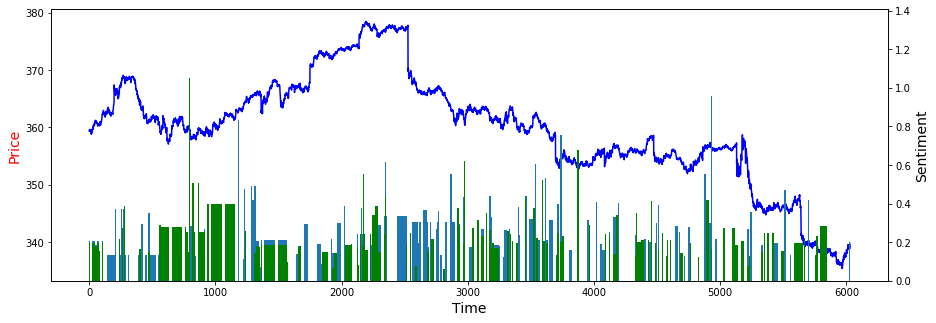

In [27]:
analyzer.plot_subreddits_day(['Economics'])

<h2>3 - Markov Chains<h2>

In [28]:
analyzer.markov_chain_data()

<h3>3.1 - Plotting Hist</h3>

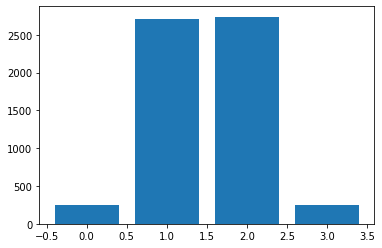

In [29]:
analyzer.plot_markov_hist()

<h3>3.2 - Nth Degree Markov Chains<h3>

In [30]:
bins = analyzer.complete_markov['Economics']
train = list(bins[:int(len(bins) * .7)])
test = list(bins[int(len(bins) * .7):])
markov = Markov()

markov.optimal_degree(train, test, 10, range(10))

NameError: name 'np' is not defined

<h3>3.3 - Optimizing Nth Degree Markov Chains<h3>

<h2>4 - Univariate LSTM Network<h2>

<h3>4.1 - Processing And Splititng Data</h3>

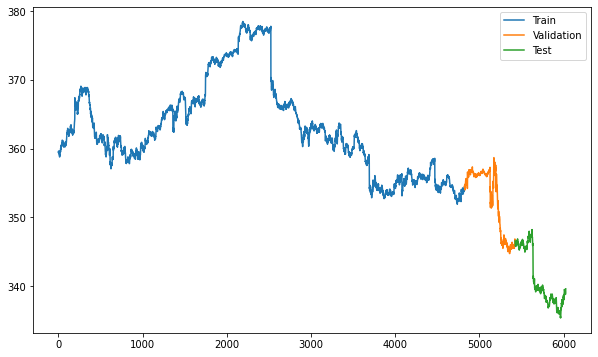

In [ ]:
uni_lstm = LSTM(analyzer.df_dict['Economics'], ['price'])
uni_lstm.divide_data()

<h3>4.2 - Fitting The Model</h3>

In [ ]:
uni_lstm.run()

<h3>4.3 - Plotting True And Predicted Values</h3>

In [ ]:
uni_lstm.plot([
    (uni_lstm.steps_train, uni_lstm.X_train, uni_lstm.y_train, 'Training'),
    (uni_lstm.steps_val, uni_lstm.X_val, uni_lstm.y_val, 'Validation'),
    (uni_lstm.steps_test, uni_lstm.X_test, uni_lstm.y_test, 'Testing'),
])


<h3>4.4 - Comparing n Values</h3>

In [ ]:
def run_comparisons(start_val, end_val):
    errors = []
    models = []
    for i in range(start_val, end_val):
        lstm = LSTM(analyzer.df_dict['Economics'], n=i)
        lstm.divide_data(plots=False)
        lstm.run()
        errors.append(lstm.hist.history['mean_absolute_error'][-1])
        models.append(lstm)

    return errors, models

In [ ]:
error, models = run_comparisons(3,10)

In [ ]:
for model in models:
    model.plot([(model.steps_test, model.X_test, model.y_test, 'Testing')])

<h2>5 - Multivariate LSTM Network Using News Sentiments</h2>

<h3>5.1 - Processing And Splitting Data </h3>

In [ ]:
multi_lstm = LSTM(analyzer.df_dict['Economics'])
multi_lstm.divide_data()

<h3>5.2 - Fitting The Model </h3>

In [ ]:
multi_lstm.run()

<h3>5.3 - Plotting True And Predicted Values </h3>

In [ ]:
multi_lstm.plot([
    (multi_lstm.steps_train, multi_lstm.X_train, multi_lstm.y_train, 'Training'),
    (multi_lstm.steps_val, multi_lstm.X_val, multi_lstm.y_val, 'Validation'),
    (multi_lstm.steps_test, multi_lstm.X_test, multi_lstm.y_test, 'Testing'),
])

<h3>5.4 - Prediction Of Future Values </h3>

In [ ]:
predictions = multi_lstm.recursive_prediction()

In [ ]:
figure(figsize=(10,6))
plt.plot(multi_lstm.steps_test, predictions)
plt.plot(multi_lstm.steps_test, multi_lstm.y_test)
plt.legend(['Recursive Predicitons', 'Test Observations'])